In [9]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import os.path

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

baseURL = "https://www.basketball-reference.com/"

def get_all_star_data(years_back=25, outfile="all_star_out.csv"):
    URL = "https://www.basketball-reference.com/allstar/"

    html = requests.get(URL)

    soup = BeautifulSoup(html.content, "html.parser")
    if soup.find('div', id="content"):
        content = soup.find('div', id="content")
    else:
        print("Failed to parse CONTENT DIV")
        print("(Likely blocked for spam)")
        return
    
    if content.find('div', id="all_all_star_games_nba"):
        allstar_div = content.find('div', id="all_all_star_games_nba")
    else:
        print("Failed to parse TOP ALL STAR DIV")
        print("(Likely blocked for spam)")
        return

    table_div = allstar_div.find('div', id="div_all_star_games_nba")
    table = table_div.find_all('tr')

    modern = table[1:years_back + 1]
    year = []
    games = []

    for rows in modern:
        data = rows.find_all('td')
        games += [data[4]]
        year += [int(data[0].text)]

    link_games = []
    for game in games:
        link_games += [game.find('a').get('href')]
    
    link_players = []
    player_yrs = []

    i = -1
    for link in link_games:
        i += 1
        curr = year[i]

        newURL = str(baseURL + link)
        html = requests.get(newURL)

        soup = BeautifulSoup(html.content, "html.parser")
        content = soup.find('div', id="content")
        teams = content.find_all('div', class_="table_wrapper")
        teams = teams[1:]

        for team in teams:
            table = team.find('table')
            body = table.find('tbody')
            rows = body.find_all('tr')
            for row in rows:
                if row.find('a'):
                    link_players += [str(row.find('a').get('href'))]
                    player_yrs += [int(curr)]

        # Forced to add pauses in order to comply with BBall Reference
        # bot scraping guidelines (forced to <20 get requests per min)
        print(str(i + 1) + " / " + str(len(link_games)) + " rosters constructed...")
        time.sleep(3)

    final_player_data = []

    i = -1
    for player in link_players:
        i += 1
        lookfor = str("per_game_stats." + str(player_yrs[i]))

        player_data = []
        newURL = str(baseURL + player)
        html = requests.get(newURL)
        soup = BeautifulSoup(html.content, "html.parser")

        meta = soup.find('div', id="info")
        meta = meta.find('div', id="meta")
        name = meta.find('h1')
        name = name.find('span').string

        player_data += [name]
        player_data += [str(player_yrs[i])]

        content = soup.find('div', id="content")        
        table = content.find('table', id="per_game_stats") # updated for new HTML of bball ref
        body = table.find('tbody')
        if body.find('tr', id=lookfor):
            year_stats = body.find('tr', id=lookfor)
            rows = year_stats.find_all('td')
            for row in rows:
                if row.find('a'):
                    player_data += [str(row.find('a').string)]
                else:
                    player_data += [str(row.string)]

        lookfor = str("advanced." + str(player_yrs[i]))
        table = content.find('table', id="advanced") # updated for new HTML of bball ref
        body = table.find('tbody')
        if body.find('tr', id=lookfor):
            year_stats = body.find('tr', id=lookfor)
            rows = year_stats.find_all('td')
            for row in rows:
                if row.find('a'):
                    player_data += [str(row.find('a').string)]
                else:
                    player_data += [str(row.string)]
        
        final_player_data += [player_data]

        print(str(i + 1) + " / " + str(len(link_players)) + " player stats compiled...")
        time.sleep(3)

    cols = ["Name", "All-Star Year", "Age", "Team", "League", "Position", "Games Played", "Games Started", "MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "Awards"]
    cols.extend([
        "Age", "Team", "Lg", "Pos", "G", "GS", "MP", "PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", 
        "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", 
        "OBPM", "DBPM", "BPM", "VORP", "Awards"
    ])
    
    df = pd.DataFrame(final_player_data)
    df.columns = cols
    df.to_csv(outfile)
    print("Finished Data Compilation. Storing in " + outfile)

def get_player_data_per_game(start_year=2000, outfile="playerdata_per_game.csv"):
    data = []
    curr = 2025
    years = []

    while curr >= start_year:
        years += [str(curr)]
        curr -= 1

    for year in years:
        url = str("https://www.basketball-reference.com/leagues/NBA_" + year + "_per_game.html")

        html = requests.get(url)

        soup = BeautifulSoup(html.content, "html.parser")
        content = soup.find('div', id="content")
        table_div  = content.find('div', id="div_per_game_stats")
        table_full = table_div.find('table', id="per_game_stats")
        body = table_full.find('tbody')
        player_rows = body.find_all('tr', class_=None)
        partials = body.find_all('tr', class_="partial_table")

        j = 0
        for row in player_rows:
            # Keeping track of current row for all rows
            # in case of mult. team
            j += 1

            # Converting table row to string array
            player = []

            all_data = row.find_all('td')
            player += [str(year)]
            for d in all_data:
                if d.find('a'):
                    player += [str(d.find('a').string)]
                else:
                    if d.string:
                        player += [str(d.string)]
                    else:
                        player += ["0"]

            if player[3] in ["TOT", "2TM", "3TM", "4TM"]:
                # get table head value
                check = row.find('th')
                new_team = ""

                while (len(partials) > j) and partials[j].find("a").string == player[1]:
                    new_team = partials[j].find_all('td')[2].string
                    j += 1

                # Set team var to last team of season
                player[3] = new_team

            data += [player]

        print(year + " player data collected")
        time.sleep(3)

    df = pd.DataFrame(data)
    cols = ["Year", "Name", "Age", "Team", "Position", "Games Played", "Games Started", "MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS", "Awards"]

    df.columns = cols
    df.to_csv(outfile)
    print("Finished Data Compilation. Storing in " + outfile)

def get_player_data_advanced(start_year=2000, outfile="playerdata_advanced.csv"):
    data = []
    curr = 2025
    years = []

    while curr >= start_year:
        years += [str(curr)]
        curr -= 1

    for year in years:
        url = str("https://www.basketball-reference.com/leagues/NBA_" + year + "_advanced.html")

        html = requests.get(url)

        soup = BeautifulSoup(html.content, "html.parser")
        content = soup.find('div', id="content")
        table_div  = content.find('div', id="div_advanced")
        table_full = table_div.find('table', id="advanced")
        body = table_full.find('tbody')
        player_rows = body.find_all('tr', class_=None)
        partials = body.find_all('tr', class_="partial_table")

        j = 0
        for row in player_rows:
            # Keeping track of current row for all rows
            # in case of mult. team
            j += 1

            # Converting table row to string array
            player = []

            all_data = row.find_all('td')
            player += [str(year)]
            for d in all_data:
                if d.find('a'):
                    player += [str(d.find('a').string)]
                else:
                    if d.string:
                        player += [str(d.string)]
                    else:
                        player += ["0"]

            if player[3] in ["TOT", "2TM", "3TM", "4TM"]:
                # get table head value
                check = row.find('th')
                new_team = ""

                while (len(partials) > j) and partials[j].find("a").string == player[1]:
                    new_team = partials[j].find_all('td')[2].string
                    j += 1

                # Set team var to last team of season
                player[3] = new_team

            data += [player]

        print(year + " player data collected")
        time.sleep(3)

    df = pd.DataFrame(data)
    cols = ["Year", "Name", "Age", "Team", "Pos", "G", "GS", "MP", "PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", 
        "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", 
        "OBPM", "DBPM", "BPM", "VORP", "Awards"
    ]
    df.columns = cols
    df.to_csv(outfile)
    print("Finished Data Compilation. Storing in " + outfile)
# get_player_data_per_game()
# get_player_data_advanced()
# get_all_star_data()

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load Data
all_star_df = pd.read_csv("all_star_out.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")
per_game_df = pd.read_csv("playerdata_per_game.csv")

# Ensure consistent column names
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)

# Merge datasets on Year + Name
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))

# Create binary label for All-Star selection
all_star_df["All_Star"] = 1
all_star_df = all_star_df[["Name", "Year", "All_Star"]]

# Merge with All-Star labels
merged_df = merged_df.merge(all_star_df, on=["Year", "Name"], how="left")
merged_df = merged_df[merged_df["Year"] != 2025]  # Drop 2025 data (rising all star)
merged_df["All_Star"].fillna(0, inplace=True)  # Non-All-Stars get label 0

# Select 500 All-Stars
all_stars = merged_df[(merged_df["All_Star"] == 1) & (merged_df["G"] >= 30)].sample(500, random_state=42)

# Select 500 Non-All-Stars (must have played at least 65 games)
non_all_stars = merged_df[(merged_df["All_Star"] == 0) & (merged_df["G"] >= 30)].sample(500, random_state=42)

# Final dataset
final_df = pd.concat([all_stars, non_all_stars]).sample(frac=1, random_state=42)  # Shuffle

# Train-Test Split
train_df, test_df = train_test_split(final_df, test_size=0.3, random_state=446)
train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

# Define feature sets
per_game_features = ["MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
adv_features = ["PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"]

# Train Logistic Regression Models
X_train_per = train_df[per_game_features]
y_train = train_df["All_Star"]
X_test_per = test_df[per_game_features]
y_test = test_df["All_Star"]

X_train_adv = train_df[adv_features]
X_test_adv = test_df[adv_features]

model_per = LogisticRegression(max_iter=10000)
model_adv = LogisticRegression(max_iter=10000)

model_per.fit(X_train_per, y_train)
model_adv.fit(X_train_adv, y_train)

# Predictions
y_pred_per = model_per.predict(X_test_per)
y_pred_adv = model_adv.predict(X_test_adv)

# Compare Accuracy
acc_per = accuracy_score(y_test, y_pred_per)
acc_adv = accuracy_score(y_test, y_pred_adv)

print(f"Per Game Model Accuracy: {acc_per:.4f}")
print(f"Advanced Stats Model Accuracy: {acc_adv:.4f}")


Per Game Model Accuracy: 0.9167
Advanced Stats Model Accuracy: 0.9133


/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_88191/2281903459.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df["All_Star"].fillna(0, inplace=True)  # Non-All-Stars get label 0


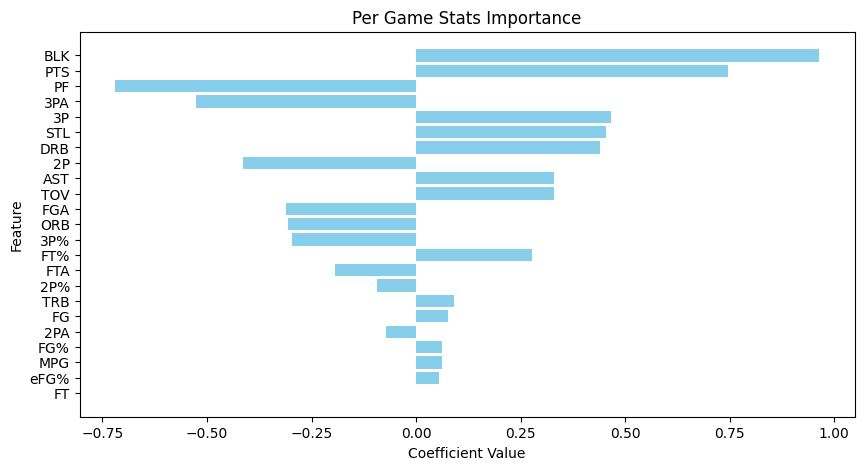

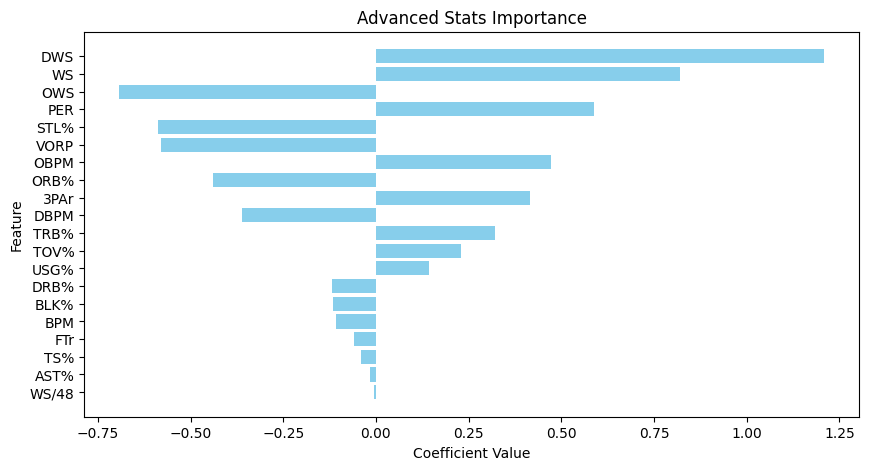

In [11]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, title):
    coef = model.coef_[0]
    importance = pd.DataFrame({"Feature": feature_names, "Coefficient": coef})
    importance["Abs_Coefficient"] = np.abs(importance["Coefficient"])
    importance = importance.sort_values(by="Abs_Coefficient", ascending=False)

    plt.figure(figsize=(10, 5))
    plt.barh(importance["Feature"], importance["Coefficient"], color="skyblue")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_feature_importance(model_per, per_game_features, "Per Game Stats Importance")
plot_feature_importance(model_adv, adv_features, "Advanced Stats Importance")


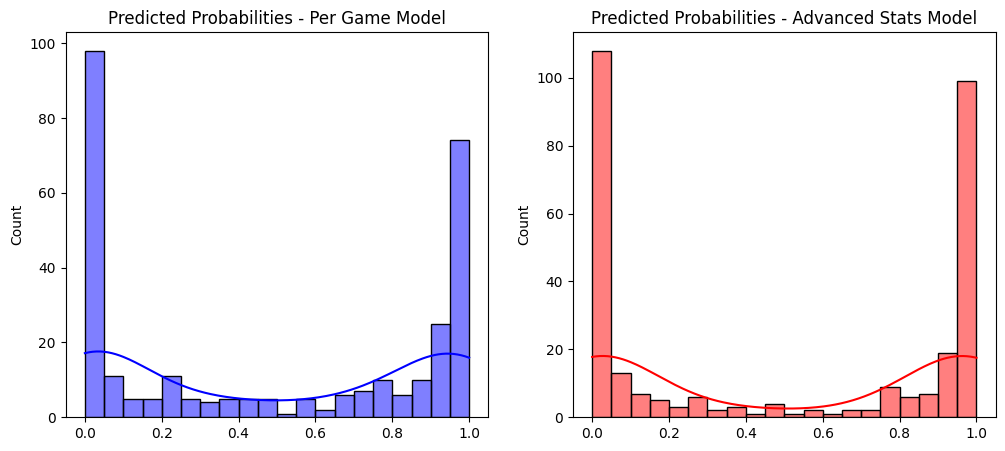

In [12]:
import seaborn as sns

# Get predicted probabilities
y_prob_per = model_per.predict_proba(X_test_per)[:, 1]
y_prob_adv = model_adv.predict_proba(X_test_adv)[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_prob_per, bins=20, kde=True, color="blue")
plt.title("Predicted Probabilities - Per Game Model")

plt.subplot(1, 2, 2)
sns.histplot(y_prob_adv, bins=20, kde=True, color="red")
plt.title("Predicted Probabilities - Advanced Stats Model")

plt.show()

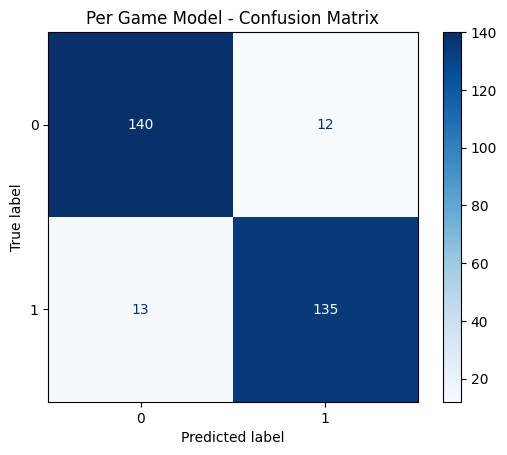

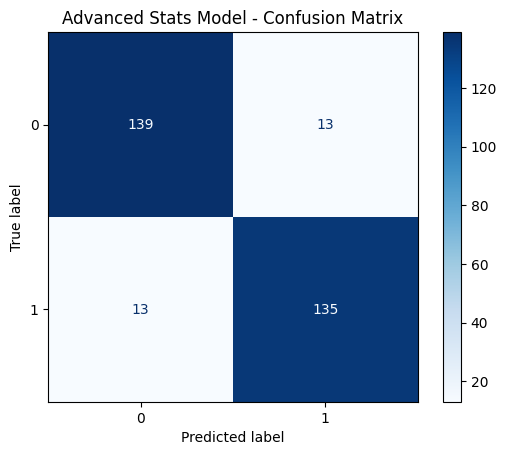

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_pred_per, "Per Game Model - Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_adv, "Advanced Stats Model - Confusion Matrix")


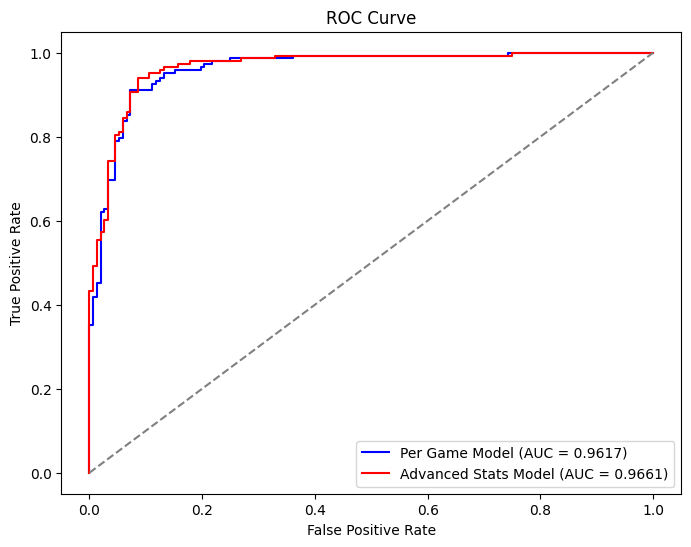

In [14]:
from sklearn.metrics import roc_curve, auc

fpr_per, tpr_per, _ = roc_curve(y_test, y_prob_per)
fpr_adv, tpr_adv, _ = roc_curve(y_test, y_prob_adv)

auc_per = auc(fpr_per, tpr_per)
auc_adv = auc(fpr_adv, tpr_adv)

plt.figure(figsize=(8, 6))
plt.plot(fpr_per, tpr_per, label=f"Per Game Model (AUC = {auc_per:.4f})", color="blue")
plt.plot(fpr_adv, tpr_adv, label=f"Advanced Stats Model (AUC = {auc_adv:.4f})", color="red")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [16]:
import numpy as np

# Add predicted probabilities and predictions to the test set
test_df["Prob_Per"] = model_per.predict_proba(X_test_per)[:, 1]
test_df["Prob_Adv"] = model_adv.predict_proba(X_test_adv)[:, 1]

test_df["Pred_Per"] = model_per.predict(X_test_per)
test_df["Pred_Adv"] = model_adv.predict(X_test_adv)

# Find most uncertain players (probability close to 50%)
test_df["Uncertainty_Per"] = np.abs(test_df["Prob_Per"] - 0.5)
test_df["Uncertainty_Adv"] = np.abs(test_df["Prob_Adv"] - 0.5)

most_uncertain_per = test_df.nsmallest(10, "Uncertainty_Per")
most_uncertain_adv = test_df.nsmallest(10, "Uncertainty_Adv")

# Confident incorrect predictions (False Positives & False Negatives)
wrong_preds_per_high = test_df[(test_df["Pred_Per"] != test_df["All_Star"]) & (test_df["Prob_Per"] > 0.7)]  # Overconfident wrong
wrong_preds_per_low = test_df[(test_df["Pred_Per"] != test_df["All_Star"]) & (test_df["Prob_Per"] < 0.3)]  # Underconfident wrong

wrong_preds_adv_high = test_df[(test_df["Pred_Adv"] != test_df["All_Star"]) & (test_df["Prob_Adv"] > 0.7)]
wrong_preds_adv_low = test_df[(test_df["Pred_Adv"] != test_df["All_Star"]) & (test_df["Prob_Adv"] < 0.3)]

# Find players where the two models strongly disagreed
disagreements = test_df[test_df["Pred_Per"] != test_df["Pred_Adv"]]

# Select columns to display (keep key stats)
display_cols = ["Year", "Name", "Age", "G", "All_Star", "Prob_Per", "Prob_Adv", "Pred_Per", "Pred_Adv"] + per_game_features + adv_features

# Save insights to a text file
with open("model_insights.txt", "w") as f:
    f.write("\nMost Uncertain Predictions (Per Game Model):\n")
    f.write(most_uncertain_per[display_cols].to_string(index=False) + "\n\n")

    f.write("\nMost Uncertain Predictions (Advanced Stats Model):\n")
    f.write(most_uncertain_adv[display_cols].to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Per Game Model) - High Confidence:\n")
    f.write(wrong_preds_per_high[display_cols].head(10).to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Per Game Model) - Low Confidence:\n")
    f.write(wrong_preds_per_low[display_cols].head(10).to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Advanced Stats Model) - High Confidence:\n")
    f.write(wrong_preds_adv_high[display_cols].head(10).to_string(index=False) + "\n\n")

    f.write("\nMost Confident Incorrect Predictions (Advanced Stats Model) - Low Confidence:\n")
    f.write(wrong_preds_adv_low[display_cols].head(10).to_string(index=False) + "\n\n")

    f.write("\nPlayers Where Models Disagreed:\n")
    f.write(disagreements[display_cols].head(10).to_string(index=False) + "\n\n")

print("Insights saved to model_insights.txt")


Insights saved to model_insights.txt



=== TOP 24 PREDICTED ALL-STARS BASED ON PER-GAME STATS ===


,Name,Team,Position,AllStar_Prob_PerGame,PTS,TRB,AST
2,Nikola Jokić,DEN,C,0.999979,29.3,12.8,10.2
1,Giannis Antetokounmpo,MIL,PF,0.999832,30.2,11.9,5.9
19,Victor Wembanyama,SAS,C,0.999621,24.3,11.0,3.7
0,Shai Gilgeous-Alexander,OKC,PG,0.999573,32.9,5.1,6.3
17,LeBron James,LAL,SF,0.998860,24.5,8.1,8.5
3,Luka Dončić,NaN,PG,0.998826,27.8,8.4,7.8
13,Anthony Davis,NaN,PF,0.998673,25.0,11.6,3.4
6,Kevin Durant,PHO,PF,0.998639,26.6,6.0,4.2
5,Jayson Tatum,BOS,PF,0.997630,27.2,8.7,6.0
10,Cade Cunningham,DET,PG,0.994761,25.7,6.1,9.2



=== TOP 24 PREDICTED ALL-STARS BASED ON ADVANCED STATS ===


,Name,Team,Position,AllStar_Prob_Advanced,PER,WS,VORP
0,Shai Gilgeous-Alexander,OKC,PG,0.999984,30.8,15.9,8.3
1,Giannis Antetokounmpo,MIL,PF,0.999888,29.8,9.6,5.5
2,Nikola Jokić,DEN,C,0.999761,32.0,14.9,8.9
5,Jayson Tatum,BOS,PF,0.998898,22.0,8.9,4.6
18,Karl-Anthony Towns,NYK,C,0.995888,23.4,9.4,3.3
30,James Harden,LAC,PG,0.995524,19.4,6.8,3.6
17,LeBron James,LAL,SF,0.993291,22.7,6.7,4.2
3,Luka Dončić,NaN,PG,0.991575,23.6,4.7,3.2
4,Anthony Edwards,MIN,SG,0.991117,19.6,7.0,3.9
10,Cade Cunningham,DET,PG,0.989473,20.1,5.4,3.2



=== MODEL COMPARISON ===
Total players predicted as All-Stars (Per Game model): 62
Total players predicted as All-Stars (Advanced model): 36

Players predicted as All-Stars by BOTH models: 36


,Name,Team,Position,AllStar_Prob_PerGame,AllStar_Prob_Advanced,PTS,PER
0,Shai Gilgeous-Alexander,OKC,PG,0.999573,0.999984,32.9,30.8
1,Giannis Antetokounmpo,MIL,PF,0.999832,0.999888,30.2,29.8
2,Nikola Jokić,DEN,C,0.999979,0.999761,29.3,32.0
3,Luka Dončić,NaN,PG,0.998826,0.991575,27.8,23.6
4,Anthony Edwards,MIN,SG,0.992049,0.991117,27.2,19.6
5,Jayson Tatum,BOS,PF,0.997630,0.998898,27.2,22.0
6,Kevin Durant,PHO,PF,0.998639,0.918287,26.6,21.1
7,Jalen Brunson,NYK,PG,0.973965,0.956175,26.3,22.0
9,Paolo Banchero,ORL,PF,0.977765,0.936770,25.9,20.4
10,Cade Cunningham,DET,PG,0.994761,0.989473,25.7,20.1


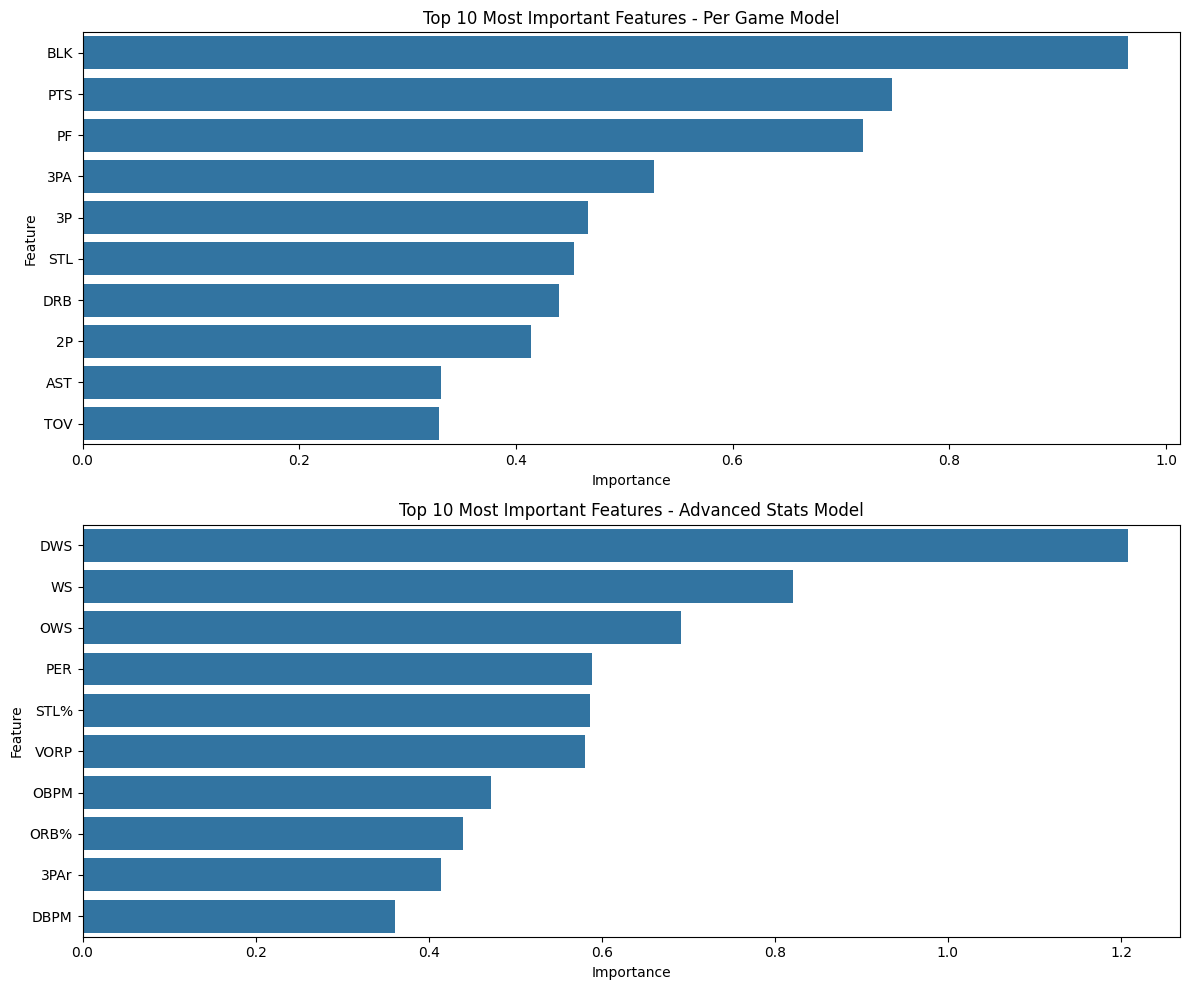

In [19]:
# Load the trained models and make predictions for 2025
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your datasets
per_game_df = pd.read_csv("playerdata_per_game.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")

# Ensure consistent column names
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)

# Merge datasets for 2025 data
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))

# Filter for 2025 season data only
data_2025 = merged_df[merged_df["Year"] == 2025]

# Filter to include only players with at least 30 games played
data_2025 = data_2025[data_2025["G"] >= 30]

# Define feature sets (same as in your training code)
per_game_features = ["MPG", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P", "2PA", "2P%", "eFG%", "FT", "FTA", "FT%", "ORB", "DRB", "TRB", "AST", "STL", "BLK", "TOV", "PF", "PTS"]
adv_features = ["PER", "TS%", "3PAr", "FTr", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%", "OWS", "DWS", "WS", "WS/48", "OBPM", "DBPM", "BPM", "VORP"]

# Make predictions for 2025
X_2025_per = data_2025[per_game_features]
X_2025_adv = data_2025[adv_features]

# Get probabilities instead of just binary predictions
prob_per = model_per.predict_proba(X_2025_per)[:, 1]  # Probability of being an All-Star
prob_adv = model_adv.predict_proba(X_2025_adv)[:, 1]

# Add predictions to the dataframe
data_2025['AllStar_Prob_PerGame'] = prob_per
data_2025['AllStar_Prob_Advanced'] = prob_adv
data_2025['AllStar_Pred_PerGame'] = (prob_per >= 0.7).astype(int)
data_2025['AllStar_Pred_Advanced'] = (prob_adv >= 0.7).astype(int)

# Display top 24 predicted All-Stars (similar to actual All-Star game roster size)
print("\n=== TOP 24 PREDICTED ALL-STARS BASED ON PER-GAME STATS ===")
top_per_game = data_2025.sort_values('AllStar_Prob_PerGame', ascending=False).head(24)
display(top_per_game[['Name', 'Team', 'Position', 'AllStar_Prob_PerGame', 'PTS', 'TRB', 'AST']])

print("\n=== TOP 24 PREDICTED ALL-STARS BASED ON ADVANCED STATS ===")
top_advanced = data_2025.sort_values('AllStar_Prob_Advanced', ascending=False).head(24)
display(top_advanced[['Name', 'Team', 'Position', 'AllStar_Prob_Advanced', 'PER', 'WS', 'VORP']])

# Compare models
print("\n=== MODEL COMPARISON ===")
total_predicted_per = data_2025['AllStar_Pred_PerGame'].sum()
total_predicted_adv = data_2025['AllStar_Pred_Advanced'].sum()
print(f"Total players predicted as All-Stars (Per Game model): {total_predicted_per}")
print(f"Total players predicted as All-Stars (Advanced model): {total_predicted_adv}")

# Find players predicted by both models
both_models = data_2025[(data_2025['AllStar_Pred_PerGame'] == 1) & (data_2025['AllStar_Pred_Advanced'] == 1)]
print(f"\nPlayers predicted as All-Stars by BOTH models: {len(both_models)}")
display(both_models[['Name', 'Team', 'Position', 'AllStar_Prob_PerGame', 'AllStar_Prob_Advanced', 'PTS', 'PER']])


# Feature importance analysis
plt.figure(figsize=(12, 10))

# Per game model feature importance
plt.subplot(2, 1, 1)
per_game_importance = pd.DataFrame({
    'Feature': per_game_features,
    'Importance': np.abs(model_per.coef_[0])
})
per_game_importance = per_game_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=per_game_importance.head(10))
plt.title('Top 10 Most Important Features - Per Game Model')

# Advanced stats model feature importance
plt.subplot(2, 1, 2)
adv_importance = pd.DataFrame({
    'Feature': adv_features,
    'Importance': np.abs(model_adv.coef_[0])
})
adv_importance = adv_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=adv_importance.head(10))
plt.title('Top 10 Most Important Features - Advanced Stats Model')

plt.tight_layout()
plt.show()

# Optional: Save the 2025 predictions to CSV
data_2025[['Name', 'Team', 'Position', 'AllStar_Prob_PerGame', 'AllStar_Prob_Advanced', 
           'AllStar_Pred_PerGame', 'AllStar_Pred_Advanced', 'PTS', 'TRB', 'AST', 'PER', 'WS', 'VORP']].to_csv('allstar_predictions_2025.csv', index=False)

In [21]:
# Train separate models for BLK and DWS and evaluate performance
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load data
train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

# Define features for separate models
blk_feature = ["BLK"]
dws_feature = ["DWS"]

# Train BLK model
X_train_blk = train_df[blk_feature]
X_test_blk = test_df[blk_feature]
y_train = train_df["All_Star"]
y_test = test_df["All_Star"]

model_blk = LogisticRegression(max_iter=10000)
model_blk.fit(X_train_blk, y_train)
y_pred_blk = model_blk.predict(X_test_blk)

# Train DWS model
X_train_dws = train_df[dws_feature]
X_test_dws = test_df[dws_feature]

model_dws = LogisticRegression(max_iter=10000)
model_dws.fit(X_train_dws, y_train)
y_pred_dws = model_dws.predict(X_test_dws)

# Print accuracies
print(f"BLK-only Model Accuracy: {accuracy_score(y_test, y_pred_blk):.4f}")
print(f"DWS-only Model Accuracy: {accuracy_score(y_test, y_pred_dws):.4f}")

# Classification reports
print("\n=== BLK MODEL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_blk))

print("\n=== DWS MODEL CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_dws))

# Print model coefficients
print(f"\nBLK Model: coef = {model_blk.coef_[0][0]:.4f}, intercept = {model_blk.intercept_[0]:.4f}")
print(f"DWS Model: coef = {model_dws.coef_[0][0]:.4f}, intercept = {model_dws.intercept_[0]:.4f}")

# Load 2025 data
per_game_df = pd.read_csv("playerdata_per_game.csv")
adv_stats_df = pd.read_csv("playerdata_advanced.csv")
adv_stats_df.rename(columns={"Pos": "Position"}, inplace=True)
merged_df = per_game_df.merge(adv_stats_df, on=["Year", "Name", "Age", "Team", "Position", "G", "GS"], suffixes=("_per", "_adv"))
data_2025 = merged_df[(merged_df["Year"] == 2025) & (merged_df["G"] >= 30)]

# Make predictions for 2025
X_2025_blk = data_2025[blk_feature]
X_2025_dws = data_2025[dws_feature]

# Get probabilities
prob_blk = model_blk.predict_proba(X_2025_blk)[:, 1]
prob_dws = model_dws.predict_proba(X_2025_dws)[:, 1]

# Add to dataframe
data_2025['AllStar_Prob_BLK'] = prob_blk
data_2025['AllStar_Prob_DWS'] = prob_dws
data_2025['AllStar_Pred_BLK'] = (prob_blk >= 0.5).astype(int)
data_2025['AllStar_Pred_DWS'] = (prob_dws >= 0.5).astype(int)

# Display top 10 predicted All-Stars from each model
print("\n=== TOP 10 PREDICTED ALL-STARS (BLK MODEL) ===")
top_blk = data_2025.sort_values('AllStar_Prob_BLK', ascending=False).head(10)
print(top_blk[['Name', 'Team', 'Position', 'AllStar_Prob_BLK', 'BLK']].to_string(index=False))

print("\n=== TOP 10 PREDICTED ALL-STARS (DWS MODEL) ===")
top_dws = data_2025.sort_values('AllStar_Prob_DWS', ascending=False).head(10)
print(top_dws[['Name', 'Team', 'Position', 'AllStar_Prob_DWS', 'DWS']].to_string(index=False))

# Total predicted all-stars
print(f"\nTotal predicted All-Stars (BLK model): {data_2025['AllStar_Pred_BLK'].sum()}")
print(f"Total predicted All-Stars (DWS model): {data_2025['AllStar_Pred_DWS'].sum()}")

BLK-only Model Accuracy: 0.5900
DWS-only Model Accuracy: 0.7567

=== BLK MODEL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         0.0       0.57      0.76      0.65       152
         1.0       0.63      0.42      0.50       148

    accuracy                           0.59       300
   macro avg       0.60      0.59      0.58       300
weighted avg       0.60      0.59      0.58       300


=== DWS MODEL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76       152
         1.0       0.76      0.74      0.75       148

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.76      0.76      0.76       300


BLK Model: coef = 1.3381, intercept = -0.8045
DWS Model: coef = 1.5665, intercept = -3.5642

=== TOP 10 PREDICTED ALL-STARS (BLK MODEL) ===
              Name Team Position  AllStar_Prob_BLK  BLK
 Vi

/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_88191/3271297176.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2025['AllStar_Prob_BLK'] = prob_blk
/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_88191/3271297176.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2025['AllStar_Prob_DWS'] = prob_dws
/var/folders/q4/47yf4cn93gnfbpp0q51bylrc0000gp/T/ipykernel_88191/3271297176.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram